# Default Setting

Executed in Colab pro environment.

* ML Framework
   - Python 3.7.10
   - Tensorflow 2.5.0

* Hardware
   - RAM: 12.7G 
   - CPU: Intel(R) Xeon(R) CPU @ 2.30GHz (1core)
   - GPU: Tesla P100-PCIE-16GB

# 0. import packages

In [1]:
# 빗썸 가상화폐 데이터 모듈
!pip install -q pybithumb

In [2]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import pybithumb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

## Data Preprocessing
- pybithumb.get_ohlcv: 빗섬의 현재 거래중인 가상화폐의 시계열 데이터를 얻어올 수 있다
- 제공되는 데이터는 측정시각,시가,종가,고가,저가,볼륨이다

In [3]:
mydf = pybithumb.get_ohlcv("ETH",interval='hour').reset_index()

In [4]:
mydf.head()

,time,open,high,low,close,volume
0,2022-01-15 17:00:00,4025000.0,4036000.0,4023000.0,4023000.0,373.662813
1,2022-01-15 18:00:00,4023000.0,4046000.0,4020000.0,4044000.0,416.052102
2,2022-01-15 19:00:00,4041000.0,4052000.0,4033000.0,4035000.0,454.511447
3,2022-01-15 20:00:00,4034000.0,4036000.0,4022000.0,4027000.0,309.148546
4,2022-01-15 21:00:00,4028000.0,4033000.0,3970000.0,3991000.0,1575.333207


In [5]:
plt.rcParams["figure.figsize"] = (15,10)

Text(0.5, 1.0, 'ETH')

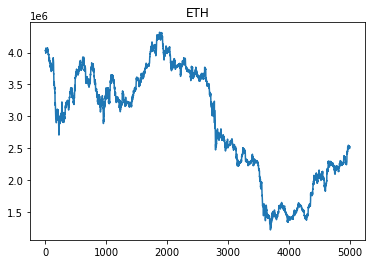

In [6]:
plt.plot(mydf['open'])
plt.title('ETH')

In [7]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

In [8]:
'''
- X는 t개의 time-step으로 이루어진 벡터
- 데이터의 순서를 보존하기 위해 train_test_split을 시행할 때 반드시 shuffle= False를 입력해야한다
'''
def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [9]:
training_data, scaler = preprocess(mydf['open'], window_size=10)

In [10]:
X_train,X_test,y_train,y_test = make_dataset(training_data, t = 168)

# MAE, MSE, RMSE: 시계열 데이터의 평가 지표들
- MAE(Mean Absolute Error):
    - $\sum_{i}|y_i-\hat{y_i}|$
- MSE(Mean Square Error)
    - $\sum_{i}(y_i-\hat{y_i})^2$
- RMSE(Root Mean Square Error)
    - $\sqrt{\sum_{i}(y_i-\hat{y_i})^2}$

In [11]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

# GRU-adaboost FIT

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

Metal device set to: Apple M1


2022-08-12 21:55:40.086121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-12 21:55:40.086396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

/var/folders/m9/0vsmjxhd7q30k5mzw0bk58hh0000gn/T/ipykernel_76400/3498737679.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)


In [15]:
final_model.fit(X_train,y_train)

Epoch 1/20


/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2022-08-12 21:55:41.073534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-12 21:55:41.617484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 21:55:41.772212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 21:55:43.837836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 10s 43ms/step - loss: 0.0142
Epoch 2/20
129/129 [==============================] - 5s 37ms/step - loss: 1.3317e-04
Epoch 3/20
129/129 [==============================] - 5s 38ms/step - loss: 8.0096e-05
Epoch 4/20
129/129 [==============================] - 5s 38ms/step - loss: 6.3976e-05
Epoch 5/20
129/129 [==============================] - 5s 38ms/step - loss: 5.5301e-05
Epoch 6/20
129/129 [==============================] - 5s 40ms/step - loss: 5.5112e-05
Epoch 7/20
129/129 [==============================] - 5s 38ms/step - loss: 4.9707e-05
Epoch 8/20
129/129 [==============================] - 5s 37ms/step - loss: 4.5370e-05
Epoch 9/20
129/129 [==============================] - 5s 39ms/step - loss: 4.6178e-05
Epoch 10/20
129/129 [==============================] - 5s 38ms/step - loss: 4.0921e-05
Epoch 11/20
129/129 [==============================] - 5s 37ms/step - loss: 4.0989e-05
Epoch 12/20
129/129 [==============================] - 5s 37ms/ste

2022-08-12 21:57:24.180653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 21:57:24.222441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 3s 19ms/step
Epoch 1/20
129/129 [==============================] - 5s 39ms/step - loss: 3.4321e-05
Epoch 2/20
129/129 [==============================] - 5s 39ms/step - loss: 2.7702e-05
Epoch 3/20
129/129 [==============================] - 5s 37ms/step - loss: 2.9648e-05
Epoch 4/20
129/129 [==============================] - 5s 41ms/step - loss: 2.9675e-05
Epoch 5/20
129/129 [==============================] - 5s 40ms/step - loss: 2.6397e-05
Epoch 6/20
129/129 [==============================] - 5s 38ms/step - loss: 3.0007e-05
Epoch 7/20
129/129 [==============================] - 5s 39ms/step - loss: 2.6944e-05
Epoch 8/20
129/129 [==============================] - 5s 42ms/step - loss: 2.6205e-05
Epoch 9/20
129/129 [==============================] - 5s 40ms/step - loss: 2.4671e-05
Epoch 10/20
129/129 [==============================] - 5s 38ms/step - loss: 2.4684e-05
Epoch 11/20
129/129 [==============================] - 5s 37ms/step - loss: 2.3103e

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x1679c4e80>,
                  n_estimators=5, random_state=42)

In [16]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

33/33 [==============================] - 1s 40ms/step


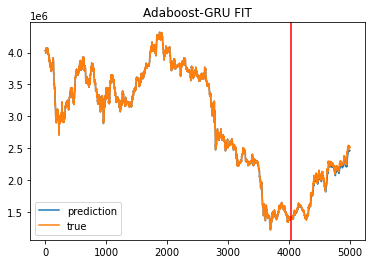

In [17]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [18]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [19]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

4.08e+04
2.73e+09
5.23e+04


# LSTM-adaboost FIT

In [20]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

/var/folders/m9/0vsmjxhd7q30k5mzw0bk58hh0000gn/T/ipykernel_76400/1043731966.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)


In [23]:
final_model.fit(X_train,y_train)

Epoch 1/20


/Users/wooseongkyun/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2022-08-12 21:59:12.016784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 21:59:12.329139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 21:59:13.588618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 8s 38ms/step - loss: 0.0168
Epoch 2/20
129/129 [==============================] - 5s 36ms/step - loss: 1.9338e-04
Epoch 3/20
129/129 [==============================] - 4s 32ms/step - loss: 1.5532e-04
Epoch 4/20
129/129 [==============================] - 4s 34ms/step - loss: 1.4816e-04
Epoch 5/20
129/129 [==============================] - 4s 34ms/step - loss: 1.3987e-04
Epoch 6/20
129/129 [==============================] - 4s 32ms/step - loss: 1.3889e-04
Epoch 7/20
129/129 [==============================] - 4s 32ms/step - loss: 1.3513e-04
Epoch 8/20
129/129 [==============================] - 4s 32ms/step - loss: 1.1784e-04
Epoch 9/20
129/129 [==============================] - 4s 32ms/step - loss: 1.3040e-04
Epoch 10/20
129/129 [==============================] - 4s 33ms/step - loss: 1.2399e-04
Epoch 11/20
129/129 [==============================] - 4s 32ms/step - loss: 1.0811e-04
Epoch 12/20
129/129 [==============================] - 4s 32ms/step

2022-08-12 22:00:40.087930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:00:40.133866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 3s 20ms/step
Epoch 1/20
129/129 [==============================] - 4s 34ms/step - loss: 6.9918e-05
Epoch 2/20
129/129 [==============================] - 4s 33ms/step - loss: 6.3604e-05
Epoch 3/20
129/129 [==============================] - 4s 34ms/step - loss: 6.1253e-05
Epoch 4/20
129/129 [==============================] - 4s 35ms/step - loss: 6.1018e-05
Epoch 5/20
129/129 [==============================] - 4s 33ms/step - loss: 6.0795e-05
Epoch 6/20
129/129 [==============================] - 4s 32ms/step - loss: 5.2257e-05
Epoch 7/20
129/129 [==============================] - 4s 33ms/step - loss: 6.2115e-05
Epoch 8/20
129/129 [==============================] - 4s 33ms/step - loss: 5.8149e-05
Epoch 9/20
129/129 [==============================] - 4s 32ms/step - loss: 4.5623e-05
Epoch 10/20
129/129 [==============================] - 4s 33ms/step - loss: 4.5957e-05
Epoch 11/20
129/129 [==============================] - 4s 34ms/step - loss: 4.7036e

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x139cd7850>,
                  n_estimators=5, random_state=42)

In [24]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

33/33 [==============================] - 1s 27ms/step


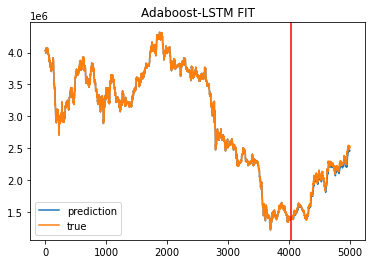

In [25]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-LSTM FIT')
plt.show()

In [26]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [27]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

4.44e+04
3.21e+09
5.66e+04


# GRU Fit

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20


2022-08-12 22:02:15.321830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:02:15.489312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:02:15.863029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - ETA: 0s - loss: 0.0330

2022-08-12 22:02:22.356789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:02:22.405434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 9s 70ms/step - loss: 0.0330 - val_loss: 0.0126
Epoch 2/20
104/104 [==============================] - 5s 44ms/step - loss: 6.7870e-04 - val_loss: 0.0016
Epoch 3/20
104/104 [==============================] - 5s 46ms/step - loss: 1.3404e-04 - val_loss: 3.3566e-04
Epoch 4/20
104/104 [==============================] - 5s 47ms/step - loss: 1.3305e-04 - val_loss: 2.2993e-04
Epoch 5/20
104/104 [==============================] - 5s 47ms/step - loss: 1.0777e-04 - val_loss: 2.2449e-04
Epoch 6/20
104/104 [==============================] - 5s 47ms/step - loss: 9.6881e-05 - val_loss: 1.9296e-04
Epoch 7/20
104/104 [==============================] - 5s 45ms/step - loss: 9.0447e-05 - val_loss: 1.5312e-04
Epoch 8/20
104/104 [==============================] - 5s 45ms/step - loss: 8.2792e-05 - val_loss: 1.5591e-04
Epoch 9/20
104/104 [==============================] - 5s 44ms/step - loss: 8.1867e-05 - val_loss: 1.6585e-04
Epoch 10/20
104/104 [=====================

In [31]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

2022-08-12 22:03:56.124602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:03:56.160927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 28ms/step


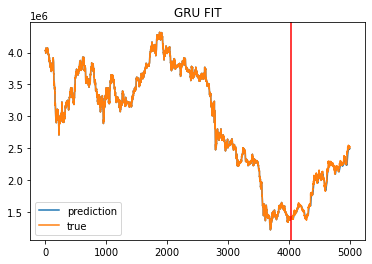

In [32]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('GRU FIT')
plt.show()

In [33]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [34]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

3.31e+04
2.06e+09
4.54e+04


# LSTM FIT

In [35]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20


2022-08-12 22:03:58.103580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:03:58.219933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:03:58.454501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - ETA: 0s - loss: 0.0183

2022-08-12 22:04:03.998186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:04:04.041250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 7s 60ms/step - loss: 0.0183 - val_loss: 0.0029
Epoch 2/20
104/104 [==============================] - 4s 43ms/step - loss: 2.6151e-04 - val_loss: 9.7927e-04
Epoch 3/20
104/104 [==============================] - 4s 41ms/step - loss: 2.0767e-04 - val_loss: 8.4637e-04
Epoch 4/20
104/104 [==============================] - 4s 43ms/step - loss: 2.1023e-04 - val_loss: 7.9190e-04
Epoch 5/20
104/104 [==============================] - 4s 41ms/step - loss: 1.9994e-04 - val_loss: 6.3229e-04
Epoch 6/20
104/104 [==============================] - 5s 44ms/step - loss: 1.9070e-04 - val_loss: 4.9199e-04
Epoch 7/20
104/104 [==============================] - 4s 43ms/step - loss: 1.7767e-04 - val_loss: 4.8953e-04
Epoch 8/20
104/104 [==============================] - 5s 45ms/step - loss: 1.7679e-04 - val_loss: 3.5911e-04
Epoch 9/20
104/104 [==============================] - 5s 45ms/step - loss: 1.5702e-04 - val_loss: 3.0753e-04
Epoch 10/20
104/104 [=================

In [38]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

2022-08-12 22:05:29.811299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 22:05:29.855815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 25ms/step


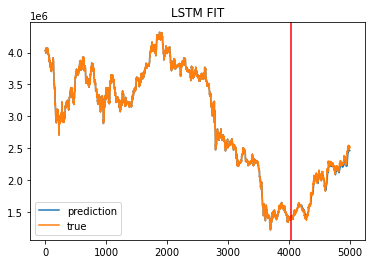

In [39]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('LSTM FIT')
plt.show()

In [40]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [41]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

4.19e+04
2.95e+09
5.43e+04
